# Model serving graph with pre-processing and post-processing


This example demonstrates how to use MLRun serving graphs and their advanced functionality including:
* Use of flow, task, model
* Build tasks from custom handlers, classes and storey components
* Test graphs locally
* Deploy the graph as a real-time serverless functions

**In this example**
- [Define functions and classes used in the graph](#define-functions-and-classes-used-in-the-graph)
- [Create a new serving function and graph](#create-a-new-serving-function-and-graph)
- [Test the function locally](#test-the-function-locally)
- [Deploy the graph as a real-time serverless function](#deploy-the-graph-as-a-real-time-serverless-function)

In [34]:
import mlrun

## Define functions and classes used in the graph

In [35]:
from cloudpickle import load
from typing import List
from sklearn.datasets import load_iris
import numpy as np

# model serving class example
class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

# echo class, custom class example
class Echo:
    def __init__(self, context, name=None, **kw):
        self.context = context
        self.name = name
        self.kw = kw
        
    def do(self, x):
        print("Echo:", self.name, x)
        return x

# error echo function, demo catching error and using custom function
def error_catcher(x):
        x.body = {"body": x.body, "origin_state": x.origin_state, "error": x.error}
        print("EchoError:", x)
        return None

In [36]:
# mark the end of the code section, DO NOT REMOVE !
# mlrun: end-code

## Create a new serving function and graph
Use `code_to_function` to convert the above code into a serving function object and initialize a graph with async flow topology.

In [37]:
function = mlrun.code_to_function("advanced", kind="serving", 
                                  image="mlrun/mlrun",
                                  requirements=['storey'])
graph = function.set_topology("flow", engine="async")
#function.verbose = True

Specify the sklearn models that are used in the ensemble.

In [39]:
models_path = 'https://s3.wasabisys.com/iguazio/models/iris/model.pkl'
path1 = models_path

Build and connect the graph (DAG) using the custom function and classes and plot the result. Add states 
using the `state.to()` method (adds a new state after the current one), or using the 
`graph.add_step()` method.

Use the `graph.error_handler()` (apply to all states) or `state.error_handler()` (apply to a specific state) if you want the error from the graph or the state to be fed into a specific state (catcher).

You can specify which state is the responder (returns the HTTP response) using the `state.respond()` method.
If you don't specify the responder, the graph is non-blocking.

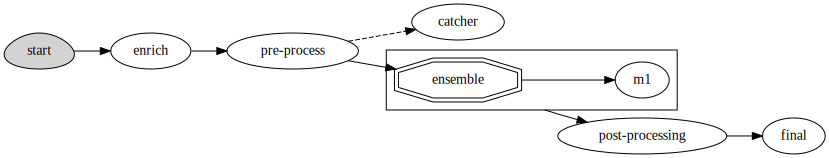

In [40]:
# use built-in storey class or our custom Echo class to create and link Task states
graph.to("storey.Extend", name="enrich", _fn='({"tag": "something"})') \
     .to(class_name="Echo", name="pre-process", some_arg='abc').error_handler("catcher")

# add an Ensemble router, the "*" prefix mark it is a router class
router = graph.add_step("*mlrun.serving.VotingEnsemble", name="ensemble", after="pre-process")
router.add_route("m1", class_name="ClassifierModel", model_path=path1)

graph.add_step(class_name="Echo", name="post-processing", after="ensemble")

# add the final step (after the router) that handles post processing and responds to the client
graph.add_step(class_name="Echo", name="final", after="post-processing").respond()

# add error handling state, run only when/if the "pre-process" state fails (keep after="")  
graph.add_step(handler="error_catcher", name="catcher", full_event=True, after="")

# plot the graph (using Graphviz) and run a test
graph.plot(rankdir='LR')

## Test the function locally
Create a test set.

In [41]:
import random
iris = load_iris()
x = random.sample(iris['data'].tolist(), 5)

Create a mock server (simulator) and test the graph with the test data.

> Note: The model and router objects support a common serving protocol API, see the [protocol and API section](model-api.md).

In [42]:
server = function.to_mock_server()
resp = server.test("/v2/models/infer", body={"inputs": x})
server.wait_for_completion()
resp

> 2022-05-26 01:02:06,521 [info] model m1 was loaded
Echo: pre-process {'inputs': [[6.0, 3.4, 4.5, 1.6], [5.3, 3.7, 1.5, 0.2], [5.7, 3.8, 1.7, 0.3], [4.8, 3.4, 1.6, 0.2], [6.2, 2.8, 4.8, 1.8]], 'tag': 'something'}
Echo: post-processing {'id': '0151a992b96a40469656ebd4ddb41967', 'model_name': 'ensemble', 'outputs': [1, 0, 0, 0, 1], 'model_version': 'v1'}
Echo: final {'id': '0151a992b96a40469656ebd4ddb41967', 'model_name': 'ensemble', 'outputs': [1, 0, 0, 0, 1], 'model_version': 'v1'}


Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator AdaBoostClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


{'id': '0151a992b96a40469656ebd4ddb41967',
 'model_name': 'ensemble',
 'outputs': [1, 0, 0, 0, 1],
 'model_version': 'v1'}

## Deploy the graph as a real-time serverless function

In [43]:
function.deploy()

> 2022-05-26 01:02:08,573 [info] Starting remote function deploy
2022-05-26 01:02:08  (info) Deploying function
2022-05-26 01:02:08  (info) Building
2022-05-26 01:02:08  (info) Staging files and preparing base images
2022-05-26 01:02:09  (info) Building processor image
2022-05-26 01:02:54  (info) Build complete
2022-05-26 01:03:02  (info) Function deploy complete
> 2022-05-26 01:03:03,121 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-default-advanced.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['default-advanced-default.default-tenant.app.us-sales-341.iguazio-cd1.com/']}


'http://default-advanced-default.default-tenant.app.us-sales-341.iguazio-cd1.com/'

<b>Invoke the remote function using the test data</b>

In [44]:
function.invoke("/v2/models/infer", body={"inputs": x})

> 2022-05-26 01:03:20,174 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-default-advanced.default-tenant.svc.cluster.local:8080/v2/models/infer'}


{'id': '858bf9ab-56c0-4e0b-97b2-bd9c003b5e47',
 'model_name': 'ensemble',
 'outputs': [1, 0, 0, 0, 1],
 'model_version': 'v1'}